## Erzeugung synthetischer AE- und Vibrationsdaten des geplanten Antriebsstrang-Demonstrators für die Entwicklung von Klassifikationsmodellen
### Voraussetzungen
 - unsere US-Sensoren haben eine hohe Sensitivität bis ca. 95kHz (Quelle: Sensordatenblatt) und wir können mit einer Abtastrate von bis zu ca. 800kHz abtasten
 - mit dem Motor erreichen wir Drehzahlen im Bereich von 300RPM bis 2300 RPM (Quelle: aktueller Motordemonstrator)
 - Schäden z.B. am Lager verursachen sog. Bursts, die mit einer Periodizität proportional zur Drehzahl auftreten (Quelle: Dirks Recherche)
 - Modellierung der Frequenz der einzelnen Lagerschäden nach https://www.sciencedirect.com/science/article/pii/S1665642314716207

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

### Parameter und daraus abgeleitete Größen

In [5]:
speed_rpm = 1000 # RPM
N_b = 8 # number of balls
d_p = 33.5 # pitch diameter
d_b = 7.9375 # ball diameter

In [6]:
bpfo = (N_b/2)*(1-(N_b/d_p)) # ball pass frequency multiplier of the outer race
bpfi = (N_b/2)*(1+(N_b/d_p)) # ball pass frequency multiplier of the inner race
bsf = (d_p/(2*d_b))*(1-(d_b/d_p)**2) # ball spin frequency multiplier
speed_hz = speed_rpm/60

In [7]:
print(f"BPFO = {bpfo}, bei 1000 RPM bedeutet das eine Frequenz von {speed_hz*bpfo} bzw. ein Event alle {1000/(speed_hz*bpfo):.2f} ms.")

BPFO = 3.044776119402985, bei 1000 RPM bedeutet das eine Frequenz von 50.74626865671642 bzw. ein Event alle 19.71 ms.


In [8]:
print(f"BPFI = {bpfi}, bei 1000 RPM bedeutet das eine Frequenz von {speed_hz*bpfi} bzw. ein Event alle {1000/(speed_hz*bpfi):.2f} ms.")

BPFI = 4.955223880597015, bei 1000 RPM bedeutet das eine Frequenz von 82.58706467661692 bzw. ein Event alle 12.11 ms.


In [9]:
print(f"BSF = {bsf}, bei 1000 RPM bedeutet das eine Frequenz von {speed_hz*bsf} bzw. ein Event alle {1000/(speed_hz*bsf):.2f} ms.")

BSF = 1.9917660712187095, bei 1000 RPM bedeutet das eine Frequenz von 33.196101186978495 bzw. ein Event alle 30.12 ms.


--> Values from the paper can be reproduced, when typo in bsf-formula (formula 3 in paper) is corrected
### Simulation von AE-Daten
 - Beispiel für Dauer eines AE-Bursts: 0.01s (https://www.researchgate.net/publication/316873412_A_method_for_reduction_of_Acoustic_Emission_AE_data_with_application_in_machine_failure_detection_and_diagnosis)


#### Gaussian Noise

In [10]:
def simulate_ae(n_time_steps, noise_level=1):
    random_noise = noise_level*np.random.standard_normal(n_time_steps)
    return random_noise

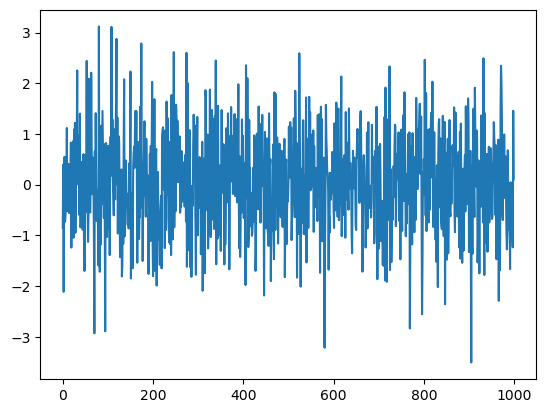

In [11]:
plt.plot(simulate_ae(n_time_steps=1000, noise_level=1))

#### AE-Bursts

In [12]:
x = np.linspace(1e-5,10,1000)
burst_len = 5 # time units
burst_period = 0.1 # time units
sigma=1
mu=0

In [13]:
def lognormal_envelope(x, sigma, mu):
    y=1/(np.sqrt(2*np.pi)*sigma*x)*np.exp(-(np.log(x)-mu)**2/(2*sigma**2))
    return y

def get_lognomal_max(sigma, mu):
    x_max = np.exp(mu-sigma**2)
    y_max = lognormal_envelope(x_max, sigma, mu)
    return x_max,y_max

def get_x_ind_at_y(val, func_vals):
    below_val = np.int32(func_vals<val)
    decay_ind = np.where((below_val-np.roll(below_val,1))!=0)[0][-1]
    return decay_ind

def get_burst_env(x, sigma, mu, burst_len):
    burst_env = lognormal_envelope(x, sigma, mu)
    burst_x_max, burst_y_max = get_lognomal_max(sigma, mu)
    x_decay_ind = get_x_ind_at_y(0.01*burst_y_max, burst_env)
    x_decay = x[x_decay_ind]
    scaling_factor = x_decay/burst_len
    burst_env = lognormal_envelope(x*scaling_factor, sigma, mu)
    return burst_env

def get_burst(x, sigma, mu, burst_len, burst_period):
    burst_env = get_burst_env(x, sigma, mu, burst_len)
    burst_oscillation = np.sin(x*(2*np.pi)/burst_period)
    return(burst_env*burst_oscillation)

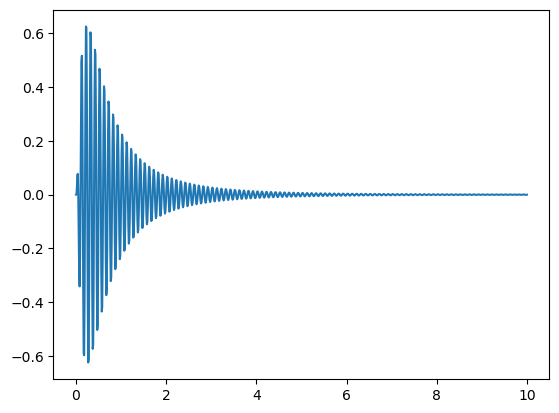

In [14]:
burst = get_burst(x, sigma, mu, burst_len, burst_period)
plt.plot(x,burst)
plt.show()

#### Simulation einer gesamten Zeitreihe

In [15]:
def get_first_burst_time(x, freq, burst_len):
    latest_start = 1/freq
    latest_start_ind = np.where((np.int32(x<latest_start)-np.roll(np.int32(x<latest_start),1))!=0)[0][-1]
    start_ind = np.random.randint(0,latest_start_ind)
    return start_ind

def mixing_function(base_stream, sig, onset):
    result = np.zeros(len(base_stream)+len(sig))
    result[:len(base_stream)] += base_stream
    for i in range(len(onset)):
        result[onset[i]:onset[i] + len(sig)] += sig 
    return result[:len(base_stream)]

def get_burst_timeseries(timeseries_len, # ms
                         discr, # n discrete values
                         burst_freq,
                         burst_len,
                         burst_sigma,
                         burst_mu,
                         burst_period
                        ):
    period = 1000/burst_freq
    ind_period = (discr/timeseries_len)*period
    
    x = np.linspace(1e-10,timeseries_len+period, discr+int(ind_period))
    start_ind = get_first_burst_time(x,burst_freq/1000,burst_len)
    n_bursts = int((discr-start_ind)//ind_period)+2
    burst_inds = np.int32(start_ind + np.arange(n_bursts)*ind_period)
    single_burst = get_burst(x[:int(10*burst_len*(discr/timeseries_len))], burst_sigma, burst_mu, burst_len, burst_period)
    burst_ts = np.zeros(discr+int(ind_period))
    burst_ts = mixing_function(burst_ts, single_burst, burst_inds)[int(ind_period):]

    return burst_ts

def create_ae_timeseries(timeseries_len=1000, # ms
                         discr = 10000, # n discrete values
                         rot_speed=speed_hz, # Hz
                         a_noise=0.0,
                         a_inner=1.0,
                         a_outer=0.0,
                         a_ball=0.0,
                         bpfo=bpfo,
                         bpfi=bpfi,
                         bsf=bsf,
                         burst_len=burst_len,
                         burst_sigma=sigma,
                         burst_mu=mu,
                         burst_osz_period=burst_period
                        ):
    ts_random_noise = a_noise*np.random.standard_normal(discr)
    
    # calculate burst frequencies
    freq_outer = bpfo*rot_speed
    freq_inner = bpfi*rot_speed
    freq_ball = bsf*rot_speed
    
    ts_outer = get_burst_timeseries(timeseries_len=timeseries_len,
                                    discr=discr,
                                    burst_freq=freq_outer,
                                    burst_len=burst_len,
                                    burst_sigma=burst_sigma,
                                    burst_mu=burst_mu,
                                    burst_period=burst_osz_period)
    ts_inner = get_burst_timeseries(timeseries_len=timeseries_len,
                                    discr=discr,
                                    burst_freq=freq_inner,
                                    burst_len=burst_len,
                                    burst_sigma=burst_sigma,
                                    burst_mu=burst_mu,
                                    burst_period=burst_osz_period)
    ts_ball = get_burst_timeseries(timeseries_len=timeseries_len,
                                   discr=discr,
                                   burst_freq=freq_ball,
                                   burst_len=burst_len,
                                   burst_sigma=burst_sigma,
                                   burst_mu=burst_mu,
                                   burst_period=burst_osz_period)
    
    ae_ts = a_noise*ts_random_noise + a_outer*ts_outer + a_inner*ts_inner + a_ball*ts_ball
    return ae_ts
    

In [16]:
#%matplotlib notebook

sampling_rate = 100000 #[Hz]
timeseries_len = 0.1 #ms
discr = int(sampling_rate*timeseries_len)

t = np.linspace(1e-10,timeseries_len, discr)

In [17]:
# Erzeugung einer Zeitreihe mit AE Impulsen
ae_ts = create_ae_timeseries(timeseries_len=100,
                             discr = 10000,
                             burst_len=10, # ms
                             burst_osz_period=0.5,
                             a_inner=10,
                             a_ball=7)

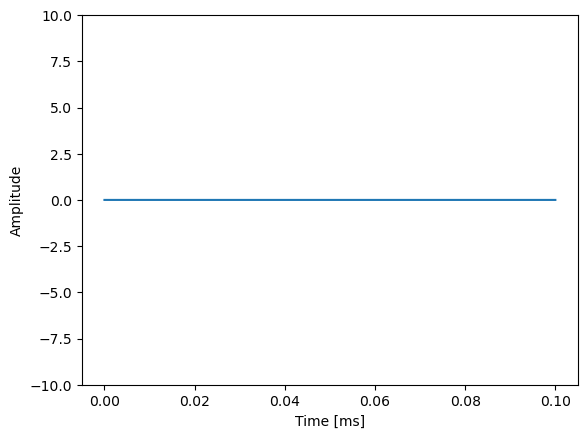

In [18]:
# regelmäßige Burst Serie zum Üben

ts_dummy = get_burst_timeseries(timeseries_len=timeseries_len,
                                    discr=discr,
                                    burst_freq=bpfo*speed_hz,
                                    burst_len=burst_len,
                                    burst_sigma=sigma,
                                    burst_mu=mu,
                                    burst_period=burst_period)
fig=plt.figure()
plt.plot(t,ts_dummy)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.ylim(-10,10)
plt.savefig("synthetic_ae_data_example.png", dpi=200)
plt.show()

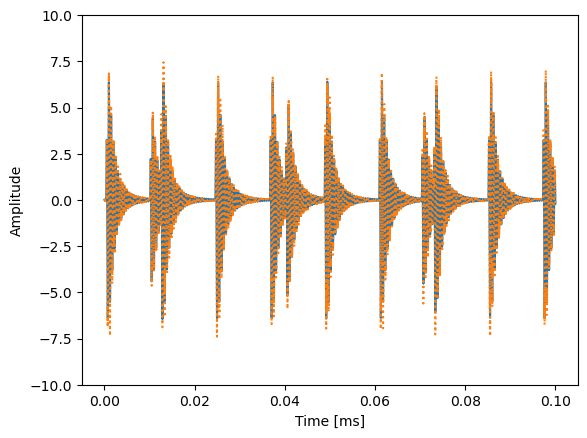

In [19]:
fig=plt.figure()
plt.plot(t,ae_ts)
# Variante mit Rauschanteil
plt.plot(t,ae_ts*(1.0+0.1*np.random.standard_normal(len(ae_ts))), color="tab:orange", linestyle=":")
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.ylim(-10,10)
plt.savefig("synthetic_ae_data_example.png", dpi=200)
plt.show()

df = pd.DataFrame(data = ae_ts, index = t)

df.to_csv("AE_test.csv")

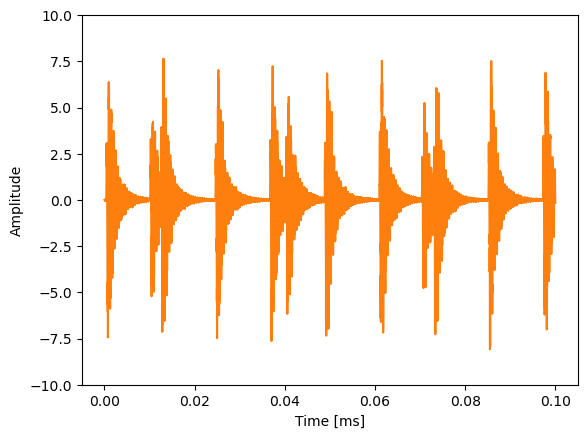

In [20]:
fig=plt.figure()
#plt.plot(t,ae_ts, lw=0.5)
plt.plot(t,ae_ts*(0.9+0.2*np.random.standard_normal(len(ae_ts))), color="tab:orange")
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.ylim(-10,10)
plt.savefig("synthetic_ae_data_example.png", dpi=200)
plt.show()

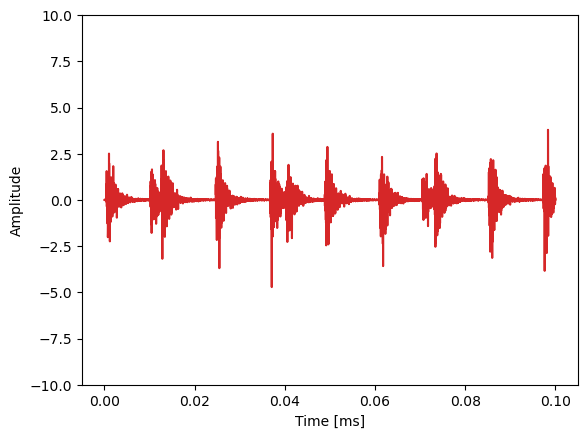

In [21]:
fig=plt.figure()
#plt.plot(t,ae_ts, lw=0.5)
plt.plot(t,ae_ts-ae_ts*(0.9+0.2*np.random.standard_normal(len(ae_ts))), color="tab:red")
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.ylim(-10,10)
plt.savefig("synthetic_ae_data_example.png", dpi=200)
plt.show()

In [22]:
t_all = np.linspace(1e-10,150, 15000)
t1 = t_all[:10000]
t2 = t_all[10000:]
ae_ts_all = create_ae_timeseries(timeseries_len=150,
                             discr = 15000,
                             burst_len=10, # ms
                             burst_osz_period=0.5,
                             a_inner=10,
                             a_ball=7)
ae_ts1=ae_ts_all[:10000]
ae_ts2=ae_ts_all[10000:]


df = pd.DataFrame(data = ae_ts_all, index = t_all)

df.to_csv("AE_test_all.csv")

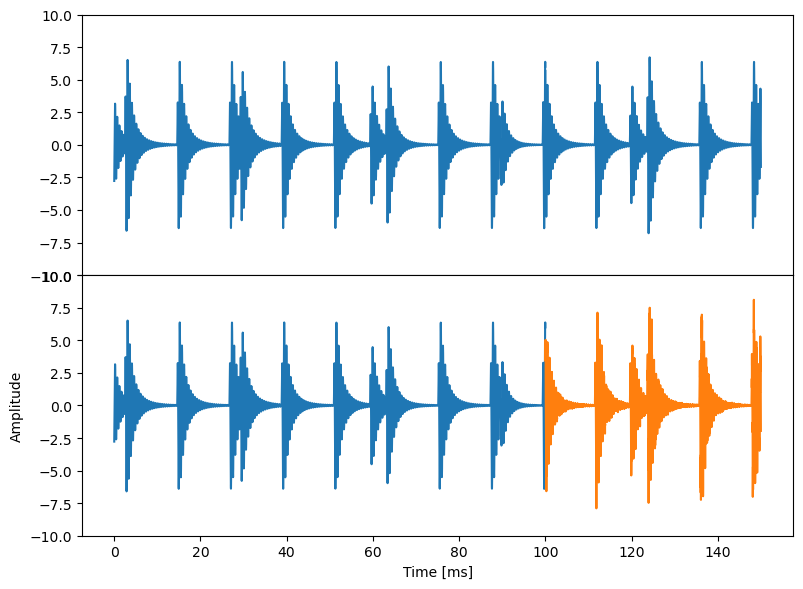

In [23]:
fig=plt.figure(figsize=(8,6))
ax1 = plt.subplot(211)
ax1.plot(t1,ae_ts1)
ax1.plot(t2,ae_ts2, color="tab:blue")
ax2 = plt.subplot(212)
ax2.plot(t1,ae_ts1)
ax2.plot(t2,ae_ts2*(0.9+0.2*np.random.standard_normal(len(ae_ts2))))
#plt.plot(t,ae_ts*(1.0+0.1*np.random.standard_normal(len(ae_ts))), color="tab:orange")
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
ax1.set_ylim(-10,10)
ax2.set_ylim(-10,10)
plt.tight_layout(h_pad=-2.1)
plt.show()

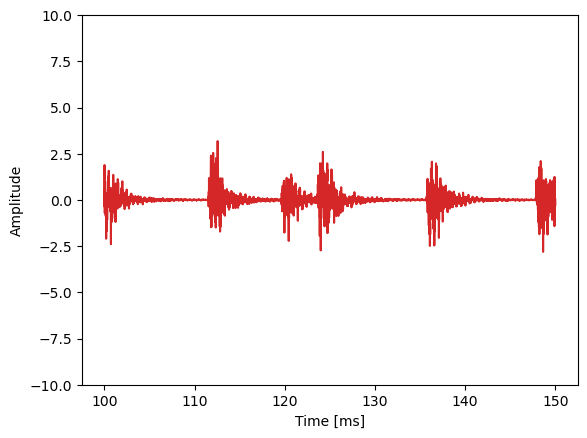

In [24]:
fig=plt.figure()
#plt.plot(t,ae_ts, lw=0.5)
plt.plot(t2,ae_ts2-ae_ts2*(0.9+0.2*np.random.standard_normal(len(ae_ts2))), color="tab:red")
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.ylim(-10,10)
plt.savefig("synthetic_ae_data_example.png", dpi=200)
plt.show()

In [25]:
t_all = np.linspace(1e-10,300, 30000)
t1a = t_all[:10000]
t1b = t_all[:20000]
t2 = t_all[20000:]
t2a = t_all[10000:]
ae_ts1_all = create_ae_timeseries(timeseries_len=300,
                             discr = 30000,
                             burst_len=10, # ms
                             burst_osz_period=0.5,
                             a_inner=10,
                             a_ball=7)
ae_ts2 = create_ae_timeseries(timeseries_len=100,
                             discr = 10000,
                             burst_len=10, # ms
                             burst_osz_period=0.5,
                             a_inner=12,
                             a_ball=11,
                             a_outer=10)
ae_ts1c=ae_ts1_all[:20000]
ae_ts1a=ae_ts1_all[:10000]
ae_ts1b=ae_ts1_all[10000:]
a2_ts_error = np.concatenate([ae_ts1c[10000:],ae_ts2])

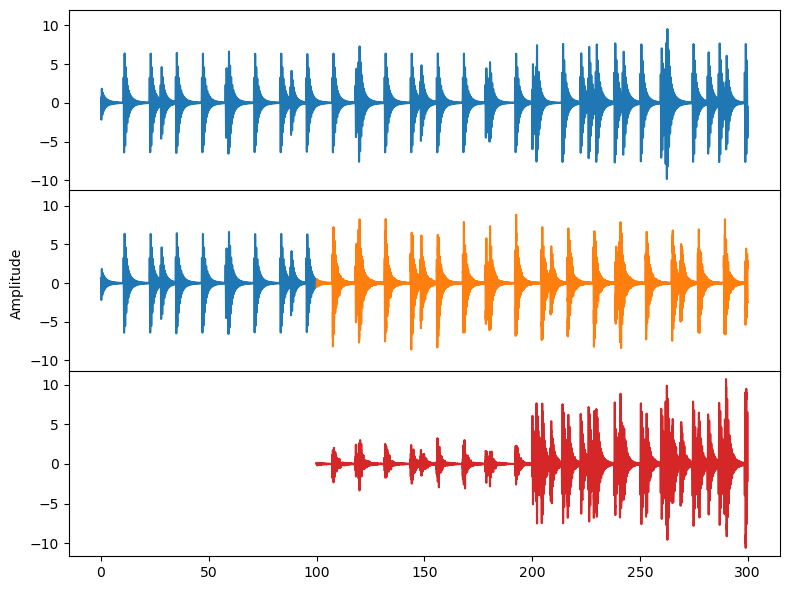

In [26]:
fig=plt.figure(figsize=(8,6))
ax1 = plt.subplot(311)
ax1.plot(t1b,ae_ts1c)
ax1.plot(t2,ae_ts2, color="tab:blue")
ax2 = plt.subplot(312)
ax2.plot(t1a,ae_ts1a)
ax2.plot(t2a,ae_ts1b*(0.9+0.2*np.random.standard_normal(len(ae_ts1b))))
#plt.plot(t,ae_ts*(1.0+0.1*np.random.standard_normal(len(ae_ts))), color="tab:orange")
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
ax1.set_ylim(-12,12)
ax2.set_ylim(-12,12)
ax3 = plt.subplot(313, sharex=ax2)
ax3.plot(t2a,ae_ts1b*(0.9+0.2*np.random.standard_normal(len(ae_ts1b)))-a2_ts_error, color="tab:red")
plt.tight_layout(h_pad=-3.5)
plt.show()